In [11]:
""" import useful functions """

import matplotlib.pyplot as plt 
from scipy.integrate import odeint, solve_bvp
import pyccl as ccl
import numpy as np
import scipy
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import mpmath as mp
from decimal import Decimal, getcontext
from scipy import interpolate

%matplotlib inline

## Define useful functions

In [2]:
""" define background functions """

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    if alpha_tilde == 0:
        ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans

# gives dE/dz

def dEdz(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    # Wang and Mota
    dEdz = Omega_k *(1 + z)/E(z , cosmo) + ((3 * Omega_m * (1 + z) ** 2)+(4 * (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 3))/\
           (2 * E(z , cosmo) * np.sqrt(X(z , cosmo)))
    
    return dEdz

# gives rho_cdm / rho_DE as a function of z for k = 0


def rho_cdm_frac_rho_de(z , cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_eval = E(z, cosmo)
    
    frac = Omega_c * (1+z) ** 3 / (Omega_lambda - alpha_tilde*(E_eval ** 4 - 2 * Omega_k * E_eval ** 2 * (1 + z) ** 2))
    return frac

# find w = P / pho for dark energy   -- for k = 0


def omega_de(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_eval = E(z, cosmo)
    
    ans = - 1 - (4 * alpha_tilde * (1 + z) * E_eval ** 3 * dEdz(z , cosmo)) / \
                (3 * (Omega_lambda - alpha_tilde*(E_eval ** 4)))
    
    return ans

def unitless_time(z , cosmo):
    t = np.zeros(len(z))
    for i in range(len(z)):
        t[i] = scipy.integrate.quad(lambda x: 1/(x*E(1/x -1,cosmo)), 0 , 1/(1+z[i]))[0]
    return t

# sound horizon
def r_s_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return mp.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2)*x))), [a_min, 1/(1+z)])

# particle horizon
def r_hor_fracH0c(z,cosmo, a_min):
    return mp.quad(lambda x: 1/((x**2)*E(1/x-1, cosmo)), [a_min, 1/(1+z)])

# Used to find z_CMB
def g1(wb):
    return (0.0783*wb**(-0.238))/(1 + 39.5*wb**(0.763))

# Used to find z_CMB
def g2(wb):
    return 0.56/(1 + 21.1*wb**(1.81))

# redshift at which the BB occurs
def z_CMB(Omg_b,Omg_m,h):
    wb = Omg_b * h**2
    wm = Omg_m * h**2
    return 1048*(1+0.00124*wb**(-0.738))*\
           (1 + g1(wb)*wm**g2(wb))

# Used to find r_s
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [125]:
"""  Define useful functions for growth """
# Define xi, caracteristic function of 4DEGB. xi(alpha_C = 1) = 1
# note: k is unitless (ie. k is actually k/H0)
def xi(a, cosmo1, k):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    if alpha_C == 0:
        return 1
    else:
        Omega_m = Omega_c + Omega_b
        Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
        return (k**2)*a**2/((k**2)*a**2 - 6*alpha_C)

# Define Ea^2 = H/H0 a^2 (a suqared to avoid singularity
def Easquared(a,cosmo1):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*a + (Omega_r + alpha_C) + Omega_k*a**(2) + Omega_lambda*a**(4))

# FUNCTIONS FOR BVP

# Second order ODE for D_+(a)
def solverGrowth(a, y, cosmo1, k):
    Omega_c = cosmo1[0]
    Omega_b = cosmo1[1]
    Omega_m = Omega_c + Omega_b
    Easq_val = Easquared(a, cosmo1)
    D , a3EdDda = y
    return np.vstack(((a3EdDda / (Easq_val*a)), 3*Omega_m*D*xi(a, cosmo1, k)/(2*Easq_val)))

# BC for our ODE. D(a=0) = 0, D(a = 1) = 1
# can set value of either function (y[0] or y[1]) at the lower (a) or upper (b) limit
def bc(ya, yb):
    return np.array([ya[0], yb[0] - 1])

# Function that returns D, f for a given cosmo, a and k
def solve_for_growth(a, cosmo1, k):
    
    # x range over which to solve fun
    x = np.logspace(-20,0,100)
    # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
    y_init = np.zeros((2, x.size))
    y_init[0] = x
    D_val = np.zeros((len(k),len(a)))
    f_val = np.zeros((len(k),len(a)))
    for i in range(len(k)):
        soln = solve_bvp(lambda x, y: solverGrowth(x, y, cosmo1, k[i]), bc, x, y_init).sol(a)
        D_val[i] = soln[0]
        a3EDdot = soln[1]
        f_val[i] = a3EDdot/(D_val[i]*Easquared(a,cosmo1))
    return D_val, f_val

In [4]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

## Background

In [5]:
# SNe processed data for E(z) (with no correlation)

z_dat = np.array([0.07,0.2,0.35,0.55,0.9,1.5])

E_err = np.array([0.023,0.02,0.037,0.063,0.12,0.83])

E_dat = np.array([0.997,1.111,1.128,1.364,1.52,2.67])

In [6]:
'''cosmological parameters except alpha'''

Omg_rad = 5.44e-5 * 3.046 * (7/8) * (4/11)**(4/3)
cosmoLCDM = [0.264 , 0.0493 , 0 , Omg_rad, 0, 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t


#define a and z intervals
z = np.linspace(0, 3 , int(1e3))
a = 1/(1+z)

In [7]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})
col = sns.color_palette("colorblind") 


/tmp/ipykernel_1124482/4236316675.py:29: RuntimeWarning: invalid value encountered in sqrt
  ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))


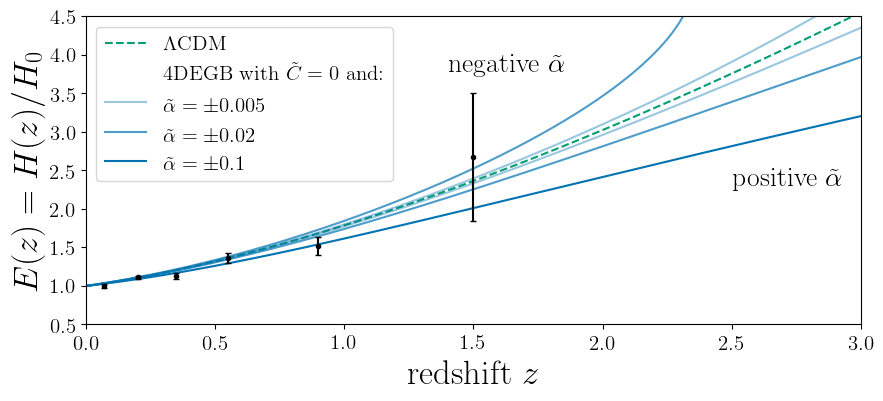

In [18]:
'''Plots of E(z)'''

# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7
plt.figure(figsize=(10,4))

plt.plot(z,E(z , cosmoLCDM), color = col[2],linestyle= "--", label = r"$\Lambda\textrm{CDM}$")

plt.plot(0,0, alpha = 0, label = r"$\textrm{4DEGB with }\tilde{C} = 0 \textrm{ and:}$")
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-3, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} = \pm %.3f$' % cosmo[-2])

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 2e-2, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.7, label = r'$\tilde{\alpha} = \pm %.2f$' % cosmo[-2])

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-1, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  \pm %.1f$' % cosmo[-2])

# -------
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, -5e-3, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.4)

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, -2e-2, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.7)

plt.text(2.5, 2.3, r"$\textrm{positive }\tilde{\alpha}$", fontfamily = "Helvetica", size = 20)
plt.text(1.4, 3.8, r"$\textrm{negative }\tilde{\alpha}$", fontfamily = "Helvetica", size = 20)

plt.errorbar(z_dat, E_dat, yerr=E_err, fmt=".k", capsize=2)
plt.xlabel(r"$\textrm{redshift }z$", size = 25)
plt.ylabel(r"$E(z) = H(z)/H_0$", size = 25);
plt.xlim(0,3)
plt.ylim(0.5,4.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(prop={'size': 15})
#plt.savefig("E_z_GL_paper.pdf", bbox_inches="tight")


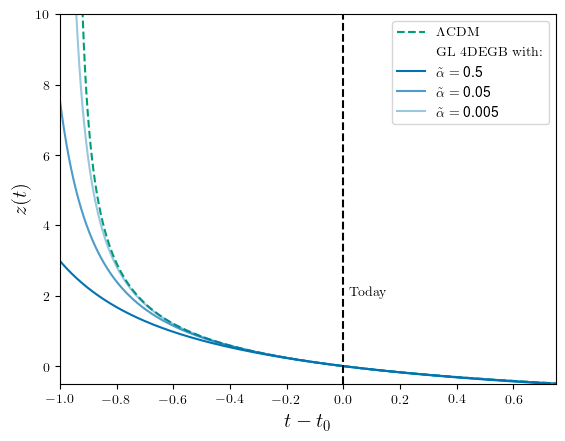

In [19]:
'''Plots of z(t)'''

z = np.linspace(-0.5, 10 , int(1e3))

plt.plot(unitless_time(z,cosmoLCDM) - unitless_time([0,0],cosmoLCDM)[0],z, color = col[2],linestyle= "--", label = r"$\Lambda \textrm{CDM}$")

plt.plot(0,0, alpha = 0, label = r"$\textrm{GL 4DEGB with:}$")

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-1, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-2, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 0.7, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-3, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
plt.plot(np.zeros(len(z)), z, "--k")
plt.text(0.02, 2.0, r"$\textrm{Today}$", fontfamily = "Helvetica")

plt.xlabel(r"$t - t_0$", size = 15)
plt.ylabel(r"$z(t)$", size = 15);
plt.legend()
plt.xlim(-1,0.75)
plt.ylim(-0.5,10)

#plt.savefig("z_of_t_paper.pdf")
plt.show()

In [ ]:
'''Plots of Sound Horizon'''

mp.mp.dps = 50
h = 0.67

#Find quantities
a_LCDM = np.linspace(2e-9,1.5, int(1e3))
a = np.linspace(2e-9,1.5, int(1e3))

r_s_LCDM = np.zeros(len(a))
r_s1 = np.zeros(len(a))
r_s2 = np.zeros(len(a))
r_s3 = np.zeros(len(a))
cosmo1 = [0.264 , 0.0493 , 0 , Omg_rad, 5e-10, 0]
cosmo2 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-11, 0]
cosmo3 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-12, 0]

for i in range(len(a)):
    r_s_LCDM[i] = r_s_fracH0c(1/a_LCDM[i] - 1,cosmoLCDM, 2e-9)
    r_s1[i] = r_s_fracH0c(1/a[i] - 1 , cosmo1, 2e-9)
    r_s2[i] = r_s_fracH0c(1/a[i] - 1 , cosmo2, 2e-9)
    r_s3[i] = r_s_fracH0c(1/a[i] - 1 , cosmo3, 2e-9)

In [ ]:
# Plot
fig = plt.figure(figsize=(14,5))
ax = plt.axes()

#big plot
ax.plot(a_LCDM,r_s_LCDM, label = r"$\textrm{LCDM}$", color = col[2], linestyle = "--")
ax.plot(0,0, alpha = 0, label = r"$\textrm{GL 4DEGB with:}$")
#ax.plot(a,r_s1, color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo1[-2]))
ax.plot(a,r_s2, color = col[0], alpha = 0.7, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo2[-2]))
ax.plot(a,r_s3, color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo3[-2]))
ax.plot(np.ones(int(1e2)), np.linspace(-1,3, int(1e2)), "k--", label = r"$\textrm{today}$")

# Make the zoom-in plot:
#axins = zoomed_inset_axes(ax, 80, loc=4) # zoom = 2
axins = inset_axes(ax, 3,1.5 , loc=4, bbox_to_anchor=(0.76, 0.15),bbox_transform=ax.figure.transFigure) # no zoom

axins.plot(a_LCDM,r_s_LCDM, label = "LCDM", color = col[2], linestyle = "--")
axins.plot(0,0, alpha = 0, label = "GL $4D$EGB with:")
#axins.plot(a,r_s1, color = col[0], alpha = 1)
axins.plot(a,r_s2, color = col[0], alpha = 0.7)
axins.plot(a,r_s3, color = col[0], alpha = 0.4)
axins.plot(2e-9*np.ones(int(1e2)), np.linspace(-1,1, int(1e2)), "k--")

axins.set_xlim(0, 5e-9)
axins.set_ylim(0, 0.5e-6)
#plt.xticks(visible=False)
#plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.text(1.01, 0.46, r"$\textbf{Today}$", fontfamily = "Helvetica")
axins.text(5e-9/5,1.025e-6, r"$\textbf{End of Nucleosynthesis }  (\large a_{min})$", fontfamily = "Helvetica")

ax.set_xlabel("a", size = 15)
ax.set_ylabel(r"unitless sound horizon $\frac{c}{H_0}r_s(a)$", size = 15)
ax.set_ylim(0,0.5)
ax.set_xlim(0,1.2)
ax.legend()
plt.draw()
#plt.savefig("soundhorizon_paper.pdf")
plt.show()

In [9]:
'''Plots of Particle Horizon'''

mp.mp.dps = 150
h = 0.67

#Find quantities
a_LCDM = np.logspace(-150,0.5, int(1e3))
a = np.logspace(-150,0.5, int(1e3))

r_s_LCDM = np.zeros(len(a))
r_s1 = np.zeros(len(a))
r_s2 = np.zeros(len(a))
r_s3 = np.zeros(len(a))
cosmo1 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-12, 0]
cosmo2 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-13, 0]
cosmo3 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-50, 0]

for i in range(len(a)):
    r_s_LCDM[i] = r_hor_fracH0c(1/a_LCDM[i] - 1,cosmoLCDM, 1e-150)
    r_s1[i] = r_hor_fracH0c(1/a[i] - 1 , cosmo1, 1e-150)
    r_s2[i] = r_hor_fracH0c(1/a[i] - 1 , cosmo2, 1e-150)
    r_s3[i] = r_hor_fracH0c(1/a[i] - 1 , cosmo3, 1e-150)
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
92
93
94
95
96
97
98
99
100
101
102
103
104
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571

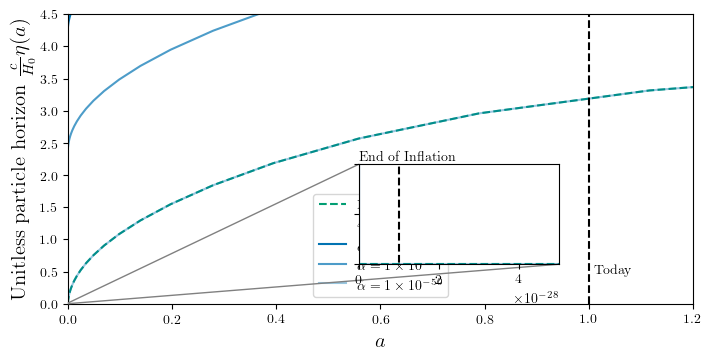

In [10]:
# Plot
fig = plt.figure(constrained_layout=True,figsize=(7,3.5))
ax = plt.axes()

#big plot
ax.plot(a_LCDM,r_s_LCDM, label = r"$\textrm{LCDM}$", color = col[2], linestyle = "--")
ax.plot(0,0, alpha = 0, label = r"$\textrm{4DEGB with:}$")
ax.plot(a,r_s1, color = col[0], alpha = 1, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
        (10**(np.log10(cosmo1[-2])-int(np.log10(cosmo1[-2])-0.1)), int(np.log10(cosmo1[-2])-0.1)))
ax.plot(a,r_s2, color = col[0], alpha = 0.7, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
        (10**(np.log10(cosmo2[-2])-int(np.log10(cosmo2[-2])-0.1)), int(np.log10(cosmo2[-2])-0.1)))
ax.plot(a,r_s3, color = col[0], alpha = 0.4, label = r"$\tilde{\alpha} = %.0f \times 10^{%d}$" % \
        (10**(np.log10(cosmo3[-2])-int(np.log10(cosmo3[-2])-0.1)), int(np.log10(cosmo3[-2])-0.1)))
ax.plot(np.ones(int(1e2)), np.linspace(0,4.5, int(1e2)), "k--")

# Make the zoom-in plot:
#axins = zoomed_inset_axes(ax, 80, loc=4) # zoom = 2
axins = inset_axes(ax, 2,1 , loc=4, bbox_to_anchor=(0.8,0.24), bbox_transform=ax.figure.transFigure) # no zoom

axins.plot(a_LCDM,r_s_LCDM, label = "LCDM", color = col[2], linestyle = "--")
axins.plot(0,0, alpha = 0, label = "$4D$EGB with:")
axins.plot(a,r_s1, color = col[0], alpha = 1)
axins.plot(a,r_s2, color = col[0], alpha = 0.7)
axins.plot(a,r_s3, color = col[0], alpha = 0.4)
axins.plot(1e-28*np.ones(int(1e2)), np.linspace(-1,1, int(1e2)), "k--")

axins.set_xlim(0, 5e-28)
axins.set_ylim(0, 1e-2)
#plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.text(1.01, 0.46, r"$\textrm{Today}$", fontfamily = "Helvetica")
axins.text(0,1.025e-2, r"$\textrm{End of Inflation}$", fontfamily = "Helvetica")

ax.set_xlabel(r"$a$", size = 15)
ax.set_ylabel(r"$\textrm{Unitless particle horizon }\frac{c}{H_0}\eta(a)$", size = 15)
ax.set_ylim(0,4.5)
ax.set_xlim(0,1.2)
ax.legend()
plt.draw()
#plt.savefig("particlehorizon_witha_paper.pdf")
plt.show()

In [12]:
a_new = np.logspace(-150,0.5, int(1e4))
r_s_LCDM_new = interpolate.make_interp_spline(a, r_s_LCDM)(a_new)
r_s1_new = interpolate.make_interp_spline(a, r_s1)(a_new)
idx_today = find_nearest_idx(a_new, 1)
idx_CMB = find_nearest_idx(a_new, 1/1101)


/tmp/ipykernel_2305485/4236316675.py:27: RuntimeWarning: overflow encountered in power
  ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)


Text(0, 0.5, '$\\textrm{conformal time}$')

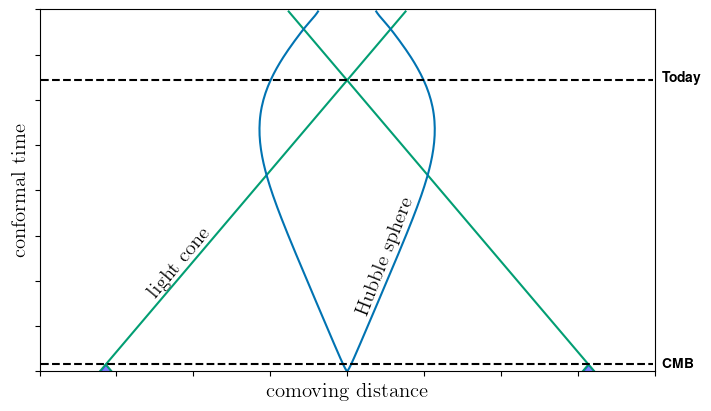

In [38]:
fig = plt.figure(constrained_layout=True,figsize=(7,4))

plt.plot(r_s_LCDM_new-r_s_LCDM_new[idx_today],r_s_LCDM_new, label = "light cone", color = col[2])
plt.plot(-r_s_LCDM_new+r_s_LCDM_new[idx_today],r_s_LCDM_new, label = "light cone", color = col[2])
plt.plot(1/(a_new*E(1/a_new - 1 , cosmoLCDM)),r_s_LCDM_new, label = "hubble sphere", color = col[0])
plt.plot(-1/(a_new*E(1/a_new - 1 , cosmoLCDM)),r_s_LCDM_new, label = "hubble sphere", color = col[0])
plt.plot(-r_s_LCDM_new[:idx_CMB]-r_s_LCDM_new[idx_today]+2*r_s_LCDM_new[idx_CMB],r_s_LCDM_new[:idx_CMB], label = "light cone", color = col[2])
plt.plot(r_s_LCDM_new[:idx_CMB]+r_s_LCDM_new[idx_today]-2*r_s_LCDM_new[idx_CMB],r_s_LCDM_new[:idx_CMB], label = "light cone", color = col[2])

plt.plot(np.linspace(-np.max(r_s_LCDM_new), np.max(r_s_LCDM_new), 100),np.ones(100)*r_s_LCDM_new[idx_today], "k--")
plt.plot(np.linspace(-np.max(r_s_LCDM_new), np.max(r_s_LCDM_new), 100),np.ones(100)*r_s_LCDM_new[idx_CMB], "k--")

plt.fill_between([r_s_LCDM_new[0]+r_s_LCDM_new[idx_today]-2*r_s_LCDM_new[idx_CMB],\
                  r_s_LCDM_new[idx_today]-r_s_LCDM_new[idx_CMB],\
                 -r_s_LCDM_new[0]+r_s_LCDM_new[idx_today]],
                [r_s_LCDM_new[0], r_s_LCDM_new[idx_CMB],0],
                [0,0,0],color="b", alpha=0.5)
plt.fill_between([-r_s_LCDM_new[0]-r_s_LCDM_new[idx_today]+2*r_s_LCDM_new[idx_CMB], \
                  -r_s_LCDM_new[idx_today]+r_s_LCDM_new[idx_CMB],\
                 r_s_LCDM_new[0]-r_s_LCDM_new[idx_today]],
                [r_s_LCDM_new[0], r_s_LCDM_new[idx_CMB],0],
                [0,0,0],color="b", alpha=0.5)

plt.text(4.1, 3.2, r"$\textbf{Today}$", fontfamily = "Helvetica", size = 10)
plt.text(4.1, 0.05, r"$\textbf{CMB}$", fontfamily = "Helvetica", size = 10)

plt.text(0.25, 0.6, r"$\textrm{Hubble sphere}$", color = 'k', rotation = 68.5,
         rotation_mode = 'anchor', size = 15)
plt.text(-2.5, 0.8, r"$\textrm{light cone}$", color = 'k', rotation = 50,
         rotation_mode = 'anchor', size = 15)

plt.xticks(visible=False)
plt.yticks(visible=False)
plt.xlim(-4,4)
plt.ylim(0,4)
plt.xlabel(r"$\textrm{comoving distance}$", fontfamily = "Helvetica", size = 15)
plt.ylabel(r"$\textrm{conformal time}$", fontfamily = "Helvetica", size = 15)

450 450


/tmp/ipykernel_2305485/4236316675.py:17: RuntimeWarning: overflow encountered in power
  return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)


(<mpl_toolkits.axes_grid1.inset_locator.BboxPatch at 0x7f6b55dc2590>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7f6b55217150>)

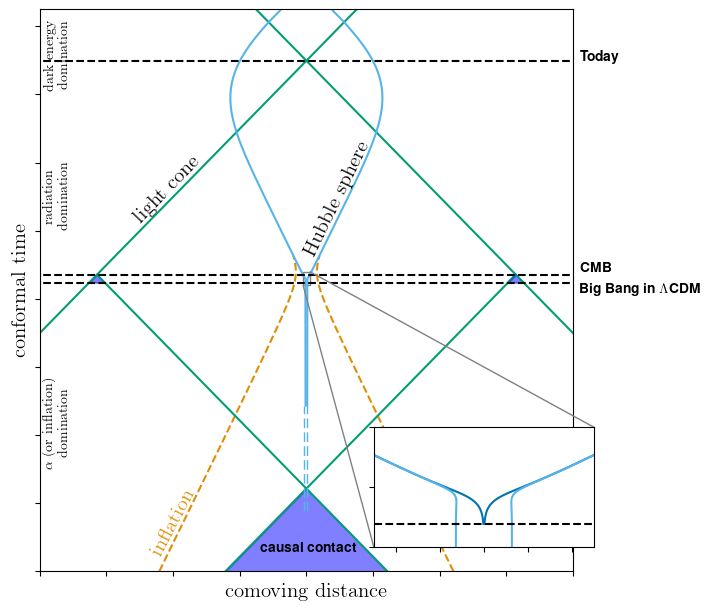

In [121]:
fig = plt.figure(constrained_layout=True,figsize=(7,6))
ax = plt.axes()

# LCDM
#x.plot(-1/(a_new[2500:]*E(1/a_new[2500:] - 1 , cosmoLCDM)),r_s1_new[2500:], label = "hubble sphere", color = col[0])
#x.plot(1/(a_new[2500:]*E(1/a_new[2500:] - 1 , cosmoLCDM)),r_s1_new[2500:], label = "hubble sphere", color = col[0])

# Inflation
ax.plot(0.5*np.sqrt(0.1+(r_s1_new[:9840]-4.4)**2),r_s1_new[:9840], label = "inflation", color = col[1], linestyle="--")
ax.plot(-0.5*np.sqrt(0.1+(r_s1_new[:9840]-4.4)**2),r_s1_new[:9840], label = "inflation", color = col[1], linestyle="--")

#4DEGB
ax.plot(r_s1_new-r_s1_new[idx_today],r_s1_new, label = "light cone", color = col[2])
ax.plot(-r_s1_new+r_s1_new[idx_today],r_s1_new, label = "light cone", color = col[2])
ax.plot(1/(a_new[5500:]*E(1/a_new[5500:] - 1 , cosmo1)),r_s1_new[5500:], label = "hubble sphere", color = col[9])
ax.plot(-1/(a_new[5500:]*E(1/a_new[5500:] - 1 , cosmo1)),r_s1_new[5500:], label = "hubble sphere", color = col[9])
ax.plot(-r_s1_new[:idx_CMB]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB],r_s1_new[:idx_CMB], label = "light cone", color = col[2])
ax.plot(r_s1_new[:idx_CMB]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],r_s1_new[:idx_CMB], label = "light cone", color = col[2])

# Dotted continuation lines
print(len(a[550:1000]),len(r_s1[100:550]))
ax.plot(-0.02 -1/(a[550:900]*E(1/a[550:900] - 1 , cosmo1)),r_s1[200:550], color = col[9], linestyle=":",linewidth=1.0, dashes=(7, 3)) 
ax.plot(1/(a[550:900]*E(1/a[550:900] - 1 , cosmo1)),r_s1[200:550], color = col[9], linestyle=":", linewidth=1.0, dashes=(7, 3)) 

#filled areas
ax.fill_between([r_s1_new[9580]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB], r_s1_new[idx_today]-r_s1_new[idx_CMB],\
                 -r_s1_new[9580]+r_s1_new[idx_today]],
                [r_s1_new[9580],r_s1_new[idx_CMB],r_s1_new[9580]],
                [r_s1_new[9580],r_s1_new[9580],r_s1_new[9580]],color="b", alpha=0.5)
ax.fill_between([-r_s1_new[9580]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB],-r_s1_new[idx_today]+r_s1_new[idx_CMB],\
                 r_s1_new[9580]-r_s1_new[idx_today]],
                [r_s1_new[9580],r_s1_new[idx_CMB],r_s1_new[9580]],
                [r_s1_new[9580],r_s1_new[9580],r_s1_new[9580]],color="b", alpha=0.5)
ax.fill_between([r_s1_new[0]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],0,\
               -r_s1_new[0]-r_s1_new[idx_today]+2*r_s1_new[idx_CMB]],
                [0,r_s1_new[find_nearest_idx(r_s1_new[:idx_CMB]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],0)],0],
                [0,0,0],color="b", alpha=0.5)


ax.plot(r_s1_new[9580:idx_CMB]+r_s1_new[idx_today]-2*r_s1_new[idx_CMB],r_s1_new[9580:idx_CMB], label = "light cone", color = col[0])

# Times
ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[idx_today], "k--")
ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[idx_CMB], "k--")
ax.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[9580], "k--")


# Zoomed in bit
axins = inset_axes(ax, 2.2,1.2 , loc=4, bbox_to_anchor=(0.85,0.085), bbox_transform=ax.figure.transFigure) # no zoom

axins.plot(-1/(a_new[9580:]*E(1/a_new[9580:] - 1 , cosmoLCDM)),r_s1_new[9580:], label = "hubble sphere", color = col[0])
axins.plot(1/(a_new[9580:]*E(1/a_new[9580:] - 1 , cosmoLCDM)),r_s1_new[9580:], label = "hubble sphere", color = col[0])
axins.plot(1/(a_new*E(1/a_new - 1 , cosmo1)),r_s1_new, label = "hubble sphere", color = col[9])
axins.plot(-1/(a_new*E(1/a_new - 1 , cosmo1)),r_s1_new, label = "hubble sphere", color = col[9])
axins.plot(np.linspace(-np.max(r_s1_new), np.max(r_s1_new), 100),np.ones(100)*r_s1_new[9580], "k--")

#Text
ax.text(4.1, 7.5, r"$\textbf{Today}$", fontfamily = "Helvetica")
ax.text(4.1, 4.4, r"$\textbf{CMB}$", fontfamily = "Helvetica")
ax.text(4.1, 4.1, r"$\textbf{Big Bang in }\Lambda\textbf{CDM}$", fontfamily = "Helvetica")
ax.text(-0.7,0.3, r"$\textbf{causal contact}$", fontfamily = "Helvetica")


ax.text(0.1, 4.6, r"$\textrm{Hubble sphere}$", color = 'k', rotation = 64,
         rotation_mode = 'anchor', size = 15)
ax.text(-2.5, 5.1, r"$\textrm{light cone}$", color = 'k', rotation = 46,
         rotation_mode = 'anchor', size = 15)

ax.text(-2.2, 0.2, r"$\textrm{inflation}$", color = col[1], rotation = 62,
         rotation_mode = 'anchor', size = 15)

ax.text(-3.6, 7.05, r"$\textrm{dark energy}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 10,multialignment='center')
ax.text(-3.6, 5, r"$\textrm{radiation}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 10, multialignment='center')
ax.text(-3.6, 1.5, r"$\alpha\textrm{ (or inflation)}$" "\n" r"$\textrm{domination}$", color = 'k', rotation = 90,
         rotation_mode = 'anchor', size = 10,multialignment='center')

axins.set_xlim(-0.05, 0.05)
axins.set_ylim(4.2, 4.4)


ax.set_xlim(-4,4)
ax.set_ylim(0,8.25)

plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)

ax.set_xlabel(r"$\textrm{comoving distance}$", fontfamily = "Helvetica", size = 15)
ax.set_ylabel(r"$\textrm{conformal time}$", fontfamily = "Helvetica", size = 15)

plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")



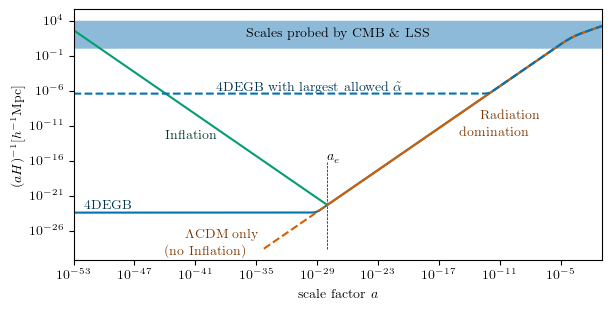

In [46]:
'''Plots for particle horizon'''
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-112, 0]
z_CMB_val = z_CMB(cosmo[1],(cosmo[0]+cosmo[1]),h)
fig = plt.figure(constrained_layout=True, figsize=(6, 3))

# Set the desired precision of Decimal
getcontext().prec = 120
alpha_t = Decimal('1e-112')
cosmotry = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),alpha_t,Decimal('0')]
cosmotry_LCDM = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('0'),Decimal('0')]

a = np.logspace(-53,-1, int(1e3),dtype=np.dtype(Decimal))
for i in range(len(a)):
    a[i] = Decimal(a[i])

idx_a_e = find_nearest_idx(a, (alpha_t)**(Decimal('0.25')))

plt.plot((alpha_t)**(Decimal('0.25'))*np.ones(len(a[int(3*idx_a_e/4):int(5*idx_a_e/4)]),dtype=np.dtype(Decimal)), \
         Decimal('3e3')/(a[int(3*idx_a_e/4):int(5*idx_a_e/4)]*E(1/a[int(3*idx_a_e/4):int(5*idx_a_e/4)] - 1 , cosmotry_LCDM)), "k--", linewidth=0.5)


plt.plot(a, Decimal('3e3')/(a*E(1/a - 1 , cosmotry)), color = col[0])

plt.plot(a[:idx_a_e], Decimal('3e3')/(E(1/a[idx_a_e] - 1 , cosmotry_LCDM)) * 1/a[:idx_a_e], label = r"$\textrm{inflation}$", color = col[2])
plt.plot(a[idx_a_e:], Decimal('3e3')/(a[idx_a_e:]*E(1/a[idx_a_e:] - 1 , cosmotry_LCDM)), color = col[3])
plt.plot(a[int(3*idx_a_e/4):idx_a_e], Decimal('3e3')/(a[int(3*idx_a_e/4):idx_a_e]*E(1/a[int(3*idx_a_e/4):idx_a_e] - 1 , cosmotry_LCDM)), color = col[3], linestyle="--")

plt.text(1e-15, 1e-10, r"$\textrm{Radiation}\newline\textrm{domination}$", fontfamily = "Helvetica", color = lighten_color(col[3], 1.3))
plt.text(1e-44, 1e-13, r"$\textrm{Inflation}$", fontfamily = "Helvetica", color = lighten_color(col[2], 1.3))
plt.text(1e-28, 1e-16, r"$a_e$", fontfamily = "Helvetica")
plt.text(1e-52, 1e-23, r"$\textrm{4DEGB}$", fontfamily = "Helvetica", color = lighten_color(col[0], 1.3))
plt.text(1e-44, 1e-27, r"$\Lambda\textrm{CDM only}\newline\textrm{(no Inflation)}$", fontfamily = "Helvetica", color=lighten_color(col[3], 1.3))
plt.text(1e-36, 5e1, r"$\textrm{Scales probed by CMB \& LSS}$", fontfamily = "Helvetica")

cosmotry2 = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('1e-44'),Decimal('0')]
plt.plot(a, Decimal('3e3')/(a*E(1/a - 1 , cosmotry2)), color = col[0], linestyle = "--")
plt.text(1e-39, 1e-6, r"$\textrm{4DEGB with largest allowed }\tilde{\alpha}$", 
         fontfamily = "Helvetica", color = lighten_color(col[0], 1.3))

plt.fill_between(a, 1, 1e4, alpha = 0.5)

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-53,1e-1)
plt.xlabel(r"$\textrm{scale factor } a$")
plt.ylabel(r"$(aH)^{-1} [h^{-1}\textrm{Mpc]}$")
#plt.savefig("particlehorizon_paper.pdf")
plt.show()

In [ ]:
'''Plots for particle horizon - seed perturbations'''
# plots inspired by https://ned.ipac.caltech.edu/level5/Narlikar/Narlikar3_1.html
h = 0.67
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-112, 0]
z_CMB_val = z_CMB(cosmo[1],(cosmo[0]+cosmo[1]),h)

# Set the desired precision of Decimal
getcontext().prec = 120
alpha_t = Decimal('1e-112')
cosmotry = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),alpha_t,Decimal('0')]
cosmotry2 = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('1e-44'),Decimal('0')]

cosmotry_LCDM = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('0'),Decimal('0')]

a = np.logspace(-53,-1, int(1e3),dtype=np.dtype(Decimal))
for i in range(len(a)):
    a[i] = Decimal(a[i])

idx_a_e = find_nearest_idx(a, (alpha_t)**(Decimal('0.25')))

plt.fill_between(a, a, Decimal('1e4')*a, alpha = 0.5)
plt.text(1e-39, 4e-39, r"$\textrm{\small Scales probed by CMB \& LSS}$", color = 'k', rotation = 21,
         rotation_mode = 'anchor')

plt.plot(a, 1/(E(1/a - 1 , cosmotry)), color = col[0])
plt.plot(a, 1/(E(1/a - 1 , cosmotry2)), color = col[0], linestyle = "--")

plt.plot(a[:idx_a_e], 1/(E(1/a[idx_a_e] - 1 , cosmotry_LCDM))*np.ones(len(a[:idx_a_e]),dtype=np.dtype(Decimal)), label = r"$\textrm{inflation}$", color = col[2])
plt.plot(a[idx_a_e:], 1/(E(1/a[idx_a_e:] - 1 , cosmotry_LCDM)), color = col[3])
plt.plot(a[int(idx_a_e/4):idx_a_e], 1/(E(1/a[int(idx_a_e/4):idx_a_e] - 1 , cosmotry_LCDM)), color = col[3], linestyle="--")
plt.plot(a, Decimal('1e-21')*a, color = col[4], linestyle=":")
#plt.plot(a, Decimal('0.005')*a, color = col[4], linestyle=":")

plt.text(1e-18, 1e-33, r"$\textrm{Radiation}\newline\textrm{domination}$", fontfamily = "Helvetica", color = lighten_color(col[3], 1.3))
plt.text(1e-52, 1e-53, r"$\textrm{Inflation}$", fontfamily = "Helvetica", color = lighten_color(col[2], 1.2))
plt.text(1e-52, 1e-83, r"$\textrm{4DEGB}$", fontfamily = "Helvetica", color = lighten_color(col[0], 1.3))
plt.text(1e-41, 1e-50, r"$\textrm{4DEGB with largest allowed }\tilde{\alpha}$", 
         fontfamily = "Helvetica", color = lighten_color(col[0], 1.3), rotation = 21,
         rotation_mode = 'anchor')
plt.text(1e-42, 1e-81, r"$\Lambda\textrm{CDM only}\newline\textrm{(no Inflation)}$", fontfamily = "Helvetica", color = lighten_color(col[3], 1.3))

plt.text(1e-29, 1e-49, r'$\lambda$',
         color = 'k', rotation = 21,
         rotation_mode = 'anchor')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-53,1e-1)
plt.xlabel(r"$\textrm{scale factor } a$")
plt.ylabel(r"$\textrm{log}(\textrm{Hubble radius } \frac{1}{H})$")
plt.gca().axes.get_yaxis().set_ticks([])
#plt.savefig("particlehorizon_lengths_paper.pdf")
plt.show()

## Perturbations

In [175]:
# New plots

# ---- COSMOLOGY, SCALES AND BOUNDARY CONDITIONS -----

# note: k is unitless (ie. k is actually k/H0)
# for simga_8, k = 2pi/(8h^-1 Mpc) \implies k/H0 = 3e5*pi/400

k_val = np.logspace(-2, -0.1, 300)*(3e5/100)

# Decide on some coordinate times
x_val = np.linspace( -7.4, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1

# Decide on some background cosmology = Omega_c , Omega_b , Omega_k , Omega_r , alpha_C
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0]
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , -5e-5]

# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])


In [176]:
""" Find D+, f and fsigma8"""

solution_growth = solve_for_growth(a_val, cosmo, k_val)
solution_growth_LCDM = solve_for_growth(a_val, cosmo_LCDM_array, k_val)
# get LCDM for only some values of k for the plot to compare to 4DEGB
k_ex1 = k_val[int(len(k_val)/2)-5: int(len(k_val)/2) + 5]
solution_growth_LCDM_ex1 = solve_for_growth(a_val, cosmo_LCDM_array, k_ex1)

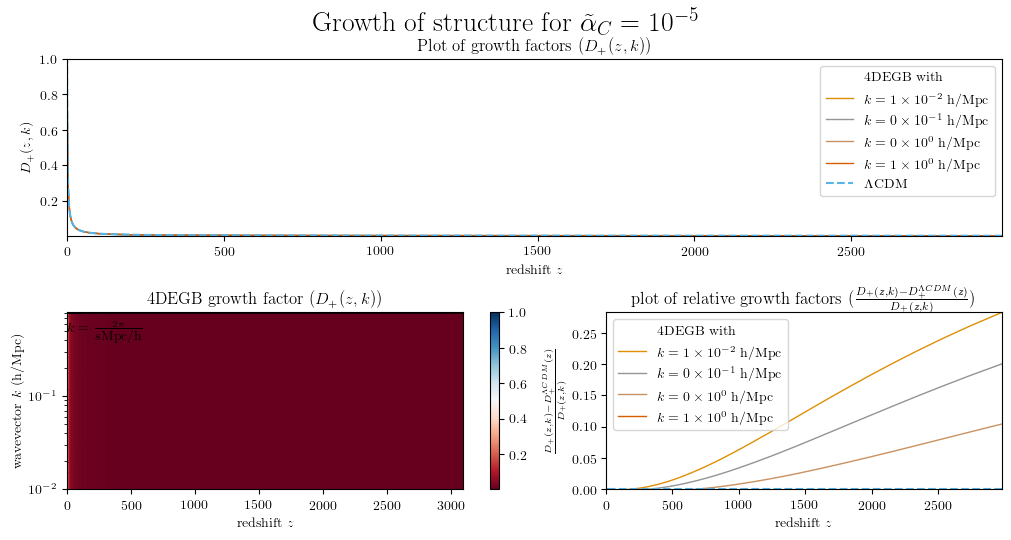

In [134]:
"""Linear Growth factor D+(a) plots"""

#fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
axs = fig.subplot_mosaic([['Top', 'Top'],['BLeft', 'BRight']],
                          gridspec_kw={'width_ratios':[1, 1]})

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/(3e5/100))
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/(3e5/100),k_val[int(len(k_val)/2)-6]/(3e5/100)])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/(3e5/100),k_val[int(len(k_val)/2)+6]/(3e5/100)])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [np.pi/4+0.005, np.pi/4 -0.005])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1/1101 - 1e-6, 1/1101 + 1e-6] , k_val/(3e5/100))

"""
# PLOT OF RELATIVE D+(a)
ax = axs[1][0]
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
ax.set_title(r'$\textrm{4DEGB growth factor relative to } \Lambda CDM \textrm{ }(\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)})$')
ax.set_ylabel(r'$\textrm{wavevector }k \textrm{ (h/Mpc)}$')
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")
fig.colorbar(c, ax=ax)
ax.set_yscale("log")
ax.set_xlabel(r'$\textrm{redshift }z$')
"""
# PLOTS OF D+(a) OF 4DEGB AND LCDM
ax = axs['BLeft']
Z = solution_growth[0]
# Plot of 4DEGB growth rate
c = ax.pcolor(X, Y, Z, vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
# Line for 8 Mpc/h ---- TODO ------------------------------------------------------------------------------------
c2 = ax.pcolor(X_8, Y_8, np.zeros((2,len(z_val))), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
ax.text(0.15, 5e-1, r"$k = \frac{2 \pi}{8\textrm{Mpc/h}}$")
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")

ax.set_title(r'$\textrm{4DEGB growth factor }(D_{+}(z,k))$')
ax.set_ylabel(r'$\textrm{wavevector }k\textrm{ (h/Mpc)}$')
ax.set_yscale("log")
ax.set_xlabel(r"$\textrm{redshift }z$")

fig.colorbar(c, ax=ax, pad=-0.02)

# 2D PLOTS OF D+(a)
ax = axs['Top']
ax.plot(1,0, alpha = 0, label = r"$\textrm{4DEGB with}$")
ax.plot(z_val, Z[0], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-0.1)), int(np.log10(k_val[0]/3000)-0.1))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-200]/3000)-int(np.log10(k_val[-200]/3000)-0.1)), int(np.log10(k_val[-200]/3000)-0.1))\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-100]/3000)-int(np.log10(k_val[-100]/3000) -0.1)), int(np.log10(k_val[-100]/3000)-0.1))\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000)-0.1)), int(np.log10(k_val[-1]/3000)-0.1))\
        , linewidth =1, color = col[3])
ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], color = col[9], linestyle = "--", label = r"$\Lambda \textrm{CDM}$")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.5, r"CMB")

#ax.text(1e-4, 0.2e-3, r"$\Lambda CDM$")
ax.set_ylabel(r"$D_{+}(z,k)$")
ax.set_xlim(z_val[-1],z_val[0])
ax.set_ylim(solution_growth_LCDM[0][int(len(k_val)/2)][0],solution_growth_LCDM[0][int(len(k_val)/2)][-1])
ax.set_title(r'$\textrm{Plot of growth factors }(D_{+}(z,k))$')
ax.set_xlabel(r"$\textrm{redshift }z$")
ax.legend()

# 2D PLOTS OF RELATIVE D+(a)
ax = axs['BRight']
ax.plot(1,0, alpha = 0, label = r"\textrm{4DEGB with}")
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
ax.plot(z_val, Z[0], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-0.1)), int(np.log10(k_val[0]/3000)-0.1))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-200]/3000)-int(np.log10(k_val[-200]/3000)-0.1)), int(np.log10(k_val[-200]/3000)-0.1))\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-100]/3000)-int(np.log10(k_val[-100]/3000) -0.1)), int(np.log10(k_val[-100]/3000)-0.1))\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000)-0.1)), int(np.log10(k_val[-1]/3000)-0.1))\
        , linewidth =1, color = col[3])
ax.plot(z_val, np.zeros(len(z_val)), color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.9, r"CMB")

#ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
ax.legend()
ax.set_title(r'$\textrm{plot of relative growth factors }(\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)})$')
ax.set_ylabel(r"$\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)}$")
ax.set_xlabel(r"$\textrm{redshift }z$")
ax.set_xlim(z_val[-1],z_val[0])
ax.set_ylim(Z[0][-1],Z[0][0])
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(z_val))))
#fig.tight_layout()
fig.suptitle(r'$\textrm{Growth of structure for } \tilde{\alpha}_C = 10^{-5}$', fontsize=20, y=1.05)
#plt.savefig("Growth_LSS_regimes.pdf", bbox_inches='tight')
plt.show()

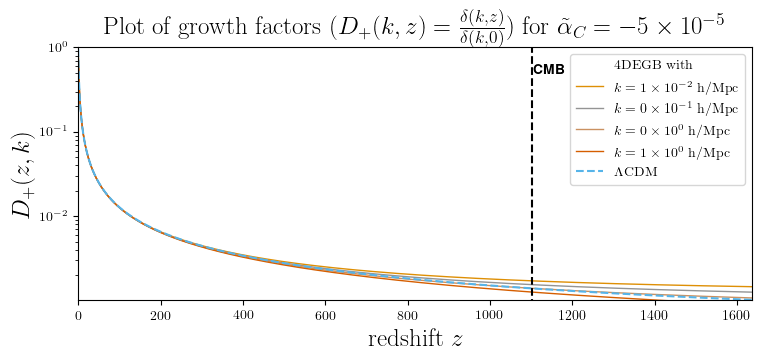

In [186]:
"""Linear Growth factor D+(a) plots"""

fig, axs = plt.subplots(1, 1, figsize=(7.5, 3.5), sharex=True, layout='constrained')

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/(3e5/100))
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/(3e5/100),k_val[int(len(k_val)/2)-6]/(3e5/100)])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/(3e5/100),k_val[int(len(k_val)/2)+6]/(3e5/100)])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [np.pi/4+0.005, np.pi/4 -0.005])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1/1101 - 1e-6, 1/1101 + 1e-6] , k_val/(3e5/100))

Z = solution_growth[0]

# 2D PLOTS OF D+(a)
ax = axs
ax.plot(1,0, alpha = 0, label = r"$\textrm{4DEGB with}$")
ax.plot(z_val, Z[0], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-0.1)), int(np.log10(k_val[0]/3000)-0.1))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-200]/3000)-int(np.log10(k_val[-200]/3000)-0.1)), int(np.log10(k_val[-200]/3000)-0.1))\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-100]/3000)-int(np.log10(k_val[-100]/3000) -0.1)), int(np.log10(k_val[-100]/3000)-0.1))\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000)-0.1)), int(np.log10(k_val[-1]/3000)-0.1))\
        , linewidth =1, color = col[3])
ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], color = col[9], linestyle = "--", label = r"$\Lambda \textrm{CDM}$")
#CMB
ax.plot(1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
ax.text(1105, 0.5, r"$\textbf{CMB}$")

#ax.text(1e-4, 0.2e-3, r"$\Lambda CDM$")
ax.set_ylabel(r"$D_{+}(z,k)$",  size = 18)
ax.set_xlim(z_val[-1],z_val[0])
ax.set_ylim(solution_growth_LCDM[0][int(len(k_val)/2)][0],solution_growth_LCDM[0][int(len(k_val)/2)][-1])
ax.set_title(r'$\textrm{Plot of growth factors }(D_{+}(k,z) = \frac{\delta(k,z)}{\delta(k,0)}) \textrm{ for } \tilde{\alpha}_C = -5 \times 10^{-5}$',  size = 18)
ax.set_yscale("log")
ax.set_xlabel(r"$\textrm{redshift }z$",  size = 18)

ax.legend()

# 2D PLOTS OF RELATIVE D+(a)
"""
ax = axs[1]
ax.plot(1,0, alpha = 0, label = r"\textrm{4DEGB with}")
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
ax.plot(z_val, Z[0], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-0.1)), int(np.log10(k_val[0]/3000)-0.1))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-200]/3000)-int(np.log10(k_val[-200]/3000)-0.1)), int(np.log10(k_val[-200]/3000)-0.1))\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-100]/3000)-int(np.log10(k_val[-100]/3000) -0.1)), int(np.log10(k_val[-100]/3000)-0.1))\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000)-0.1)), int(np.log10(k_val[-1]/3000)-0.1))\
        , linewidth =1, color = col[3])
ax.plot(z_val, np.zeros(len(z_val)), color = col[9], linestyle = "--")
#CMB
ax.plot(1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
ax.text(1105, 0.12, r"$\textbf{CMB}$")
"""
#ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
#ax.legend()
#ax.set_title(r'$\textrm{plot of relative growth factors }(\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)})$',  size = 18)
#ax.set_ylabel(r"$\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)}$",  size = 18)
#ax.set_xlabel(r"$\textrm{redshift }z$",  size = 18)
#ax.set_xlim(z_val[-1],z_val[0])
#ax.set_ylim(Z[0][-1],Z[0][0])
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(z_val))))
#fig.tight_layout()
#fig.suptitle(r'$\textrm{Growth of structure for } \tilde{\alpha}_C = -10^{-5}$', fontsize=20, y=1.05)
#plt.tight_layout()
#plt.savefig("Growth_LSS_CMB.pdf", bbox_inches='tight')

plt.show()

In [ ]:
# Define new scales for CMB comparison
k_val = np.logspace(-3, 0, 300)*(3e5/100)

# Decide on some coordinate times
x_val = np.linspace( -8.5, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1

# Decide on some background cosmology = Omega_c , Omega_b , Omega_k , Omega_r , alpha_C
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0]
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-5]

# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])

""" Find D+, f and fsigma8"""

solution_growth = solve_for_growth(a_val, cosmo, k_val)
solution_growth_LCDM = solve_for_growth(a_val, cosmo_LCDM_array, k_val)
# get LCDM for only some values of k for the plot to compare to 4DEGB
k_ex1 = k_val[int(len(k_val)/2)-5: int(len(k_val)/2) + 5]
solution_growth_LCDM_ex1 = solve_for_growth(a_val, cosmo_LCDM_array, k_ex1)

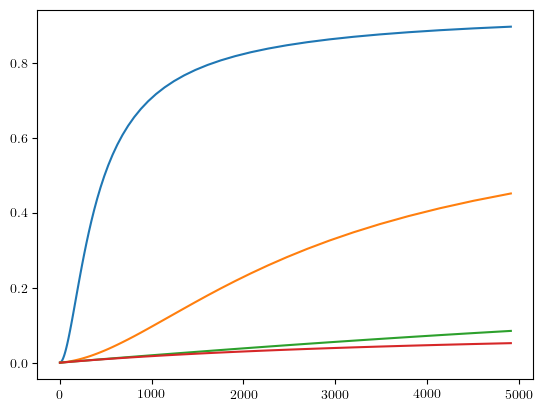

In [206]:
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]

plt.plot(z_val, Z[0])
plt.plot(z_val, Z[-200])
plt.plot(z_val, Z[-100])
plt.plot(z_val, Z[-1])

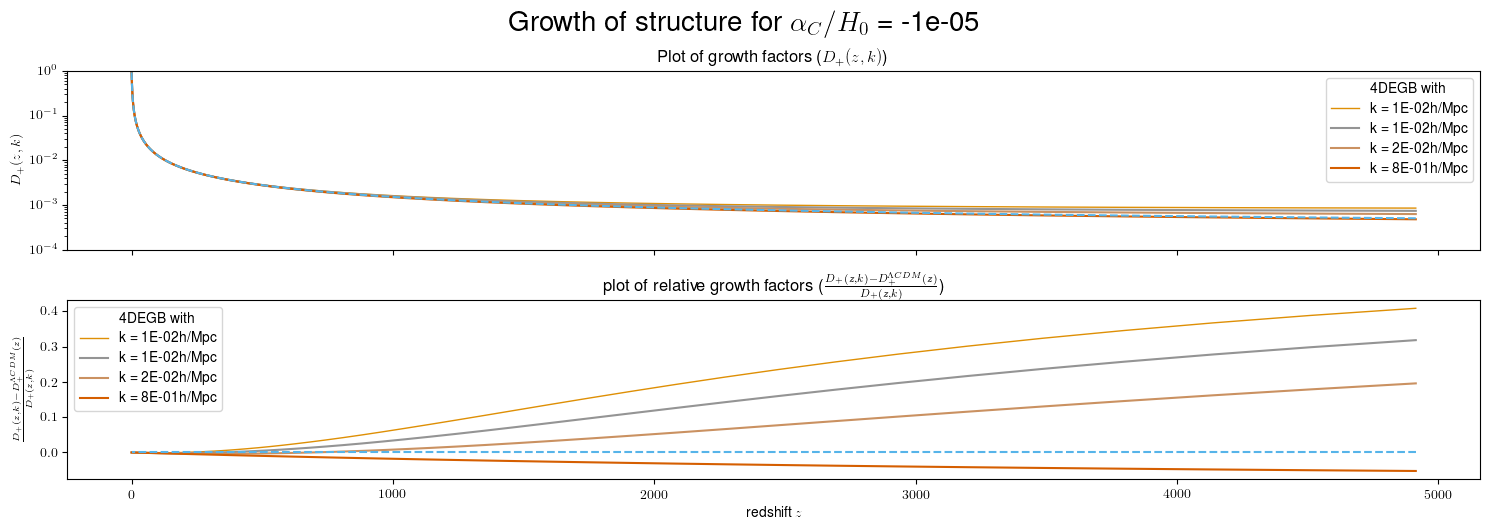

In [129]:
"""Linear Growth factor D+(a) plots"""

fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/(3e5/100))
# reduced k space for LCDM example
X_ex1, Y_ex1 = np.meshgrid(z_val, k_ex1/(3e5/100))
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/(3e5/100),k_val[int(len(k_val)/2)-6]/(3e5/100)])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/(3e5/100),k_val[int(len(k_val)/2)+6]/(3e5/100)])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [np.pi/4+0.005, np.pi/4 -0.005])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1/1101 - 1e-6, 1/1101 + 1e-6] , k_val/(3e5/100))

# 2D PLOTS OF D+(a)
ax = axs[0]
Z = solution_growth[0]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.5, r"CMB")

#ax.text(1e-4, 0.2e-3, r"$\Lambda CDM$")
ax.set_ylabel(r"$D_{+}(z,k)$")
ax.set_ylim(1e-4,1)
ax.set_yscale("log")
ax.set_title(r'Plot of growth factors ($D_{+}(z,k)$)')
ax.legend()

# 2D PLOTS OF RELATIVE D+(a)
ax = axs[1]
ax.plot(1,0, alpha = 0, label = "4DEGB with")
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
ax.plot(z_val, Z[0], label = "k = {:.0E}h/Mpc".format(k_val[0]/3000), linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = "k = {:.0E}h/Mpc".format(k_val[-280]/3000), color = col[7])
ax.plot(z_val, Z[-250], label = "k = {:.0E}h/Mpc".format(k_val[-250]/3000), color = col[5])
ax.plot(z_val, Z[-1], label = "k = {:.0E}h/Mpc".format(k_val[-1]/3000), color = col[3])
ax.plot(z_val, np.zeros(len(z_val)), color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.9, r"CMB")

#ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
ax.legend()
ax.set_title(r'plot of relative growth factors ($\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)}$)')
ax.set_ylabel(r"$\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)}$")
ax.set_xlabel(r"redshift $z$")
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(z_val))))
fig.tight_layout()
fig.suptitle(r'Growth of structure for $\alpha_C/H_0$ = {}'.format(cosmo[-1]), fontsize=20, y=1.05)

plt.xlim(0,3000)
plt.show()